# Masking

This tutorial explores ramannoodle's masking features. Ramannoodle's `InterpolationModel`, as well it's subclasses (such as `ARTModel`), can be modified by "masking" specified degrees of freedom (DOFs). When a DOF is masked, it is excluded when calculating polarizabilities and therefore will not be accounted for when calculating Raman spectra. Raman spectra computed with masking should be regarded as *partial Raman spectra*. By choosing the masks wisely, quite a bit can be learned about which atom (or groups of atoms) correspond to which features in the simulated Raman spectra.

We'll import everything we'll need up front, as well add some customizations for matplotlib.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib_inline

import ramannoodle.io.vasp as vasp_io
from ramannoodle.polarizability.art import ARTModel
from ramannoodle.symmetry import structural_utils
from ramannoodle.spectrum.spectrum_utils import convolve_spectrum

matplotlib_inline.backend_inline.set_matplotlib_formats('png')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["mathtext.default"] = 'regular'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['lines.linewidth'] = 1.5

We will be computing TiO2's Raman spectrum using data available in `tests/data/TiO2`. We will be basing this spectrum on frozen phonon calculations and use `ARTModel` to estimate phonon polarizabilities.

In [2]:
data_dir = "../../../test/data/TiO2"
# phonon_OUTCAR contains phonons (duh) as well as the equilibrium TiO2 structure.
phonon_outcar = f"{data_dir}/phonons_OUTCAR"

# Read the phonons
phonons = vasp_io.outcar.read_phonons(phonon_outcar)
# Read the reference structure. This might take a few moments...
ref_structure = vasp_io.outcar.read_ref_structure(phonon_outcar)


Now that we have the reference structure, we can start building the polarizability model.

In [3]:
# We'll need the polarizability of the equilibrium structure. 
_, equilibrium_polarizability = vasp_io.outcar.read_positions_and_polarizability(
   f"{data_dir}/ref_eps_OUTCAR"
)
model = ARTModel(ref_structure, equilibrium_polarizability)
model

╭──────────────┬──────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions   │ Specified   │   Equivalent atoms │
├──────────────┼──────────────┼─────────────┼────────────────────┤
│            0 │              │ 0/3         │                 35 │
│           36 │              │ 0/3         │                 71 │
╰──────────────┴──────────────┴─────────────┴────────────────────╯

The `__repr__` method of `ARTModel` allows us to track out progress as we build up the model. We set up the model by feeding in files containing displacements and polarizabilities. 

In [4]:
# OUTCARS are polarizability calculation where atom 5 (Ti) 
# was displaced +0.1 and +0.2 angstrom in the x direction
model.add_art_from_files(
    [f"{data_dir}/Ti5_0.1x_eps_OUTCAR"], file_format = 'outcar'
  )
model.add_art_from_files(
    [f"{data_dir}/Ti5_0.1z_eps_OUTCAR"],file_format = 'outcar'
  )
model.add_art_from_files(
    [f"{data_dir}/O43_0.1z_eps_OUTCAR", f"{data_dir}/O43_m0.1z_eps_OUTCAR"], 
    file_format="outcar"
)
model.add_art_from_files(
    [f"{data_dir}/O43_0.1x_eps_OUTCAR"], file_format = 'outcar'
)
model.add_art_from_files([f"{data_dir}/O43_0.1y_eps_OUTCAR"],file_format = 'outcar')
model

╭──────────────┬─────────────────────────────────────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions                                  │ Specified   │   Equivalent atoms │
├──────────────┼─────────────────────────────────────────────┼─────────────┼────────────────────┤
│            0 │ [-1. -0. +0.], [-0. -1. -0.], [-0. -0. +1.] │ 3/3         │                 35 │
│           36 │ [+0. +0. +1.], [+1. +0. -0.], [+0. +1. -0.] │ 3/3         │                 71 │
╰──────────────┴─────────────────────────────────────────────┴─────────────┴────────────────────╯

From the "Specified" column, we see that all degrees of freedom have been specified. We are now ready to do some Raman calculations!

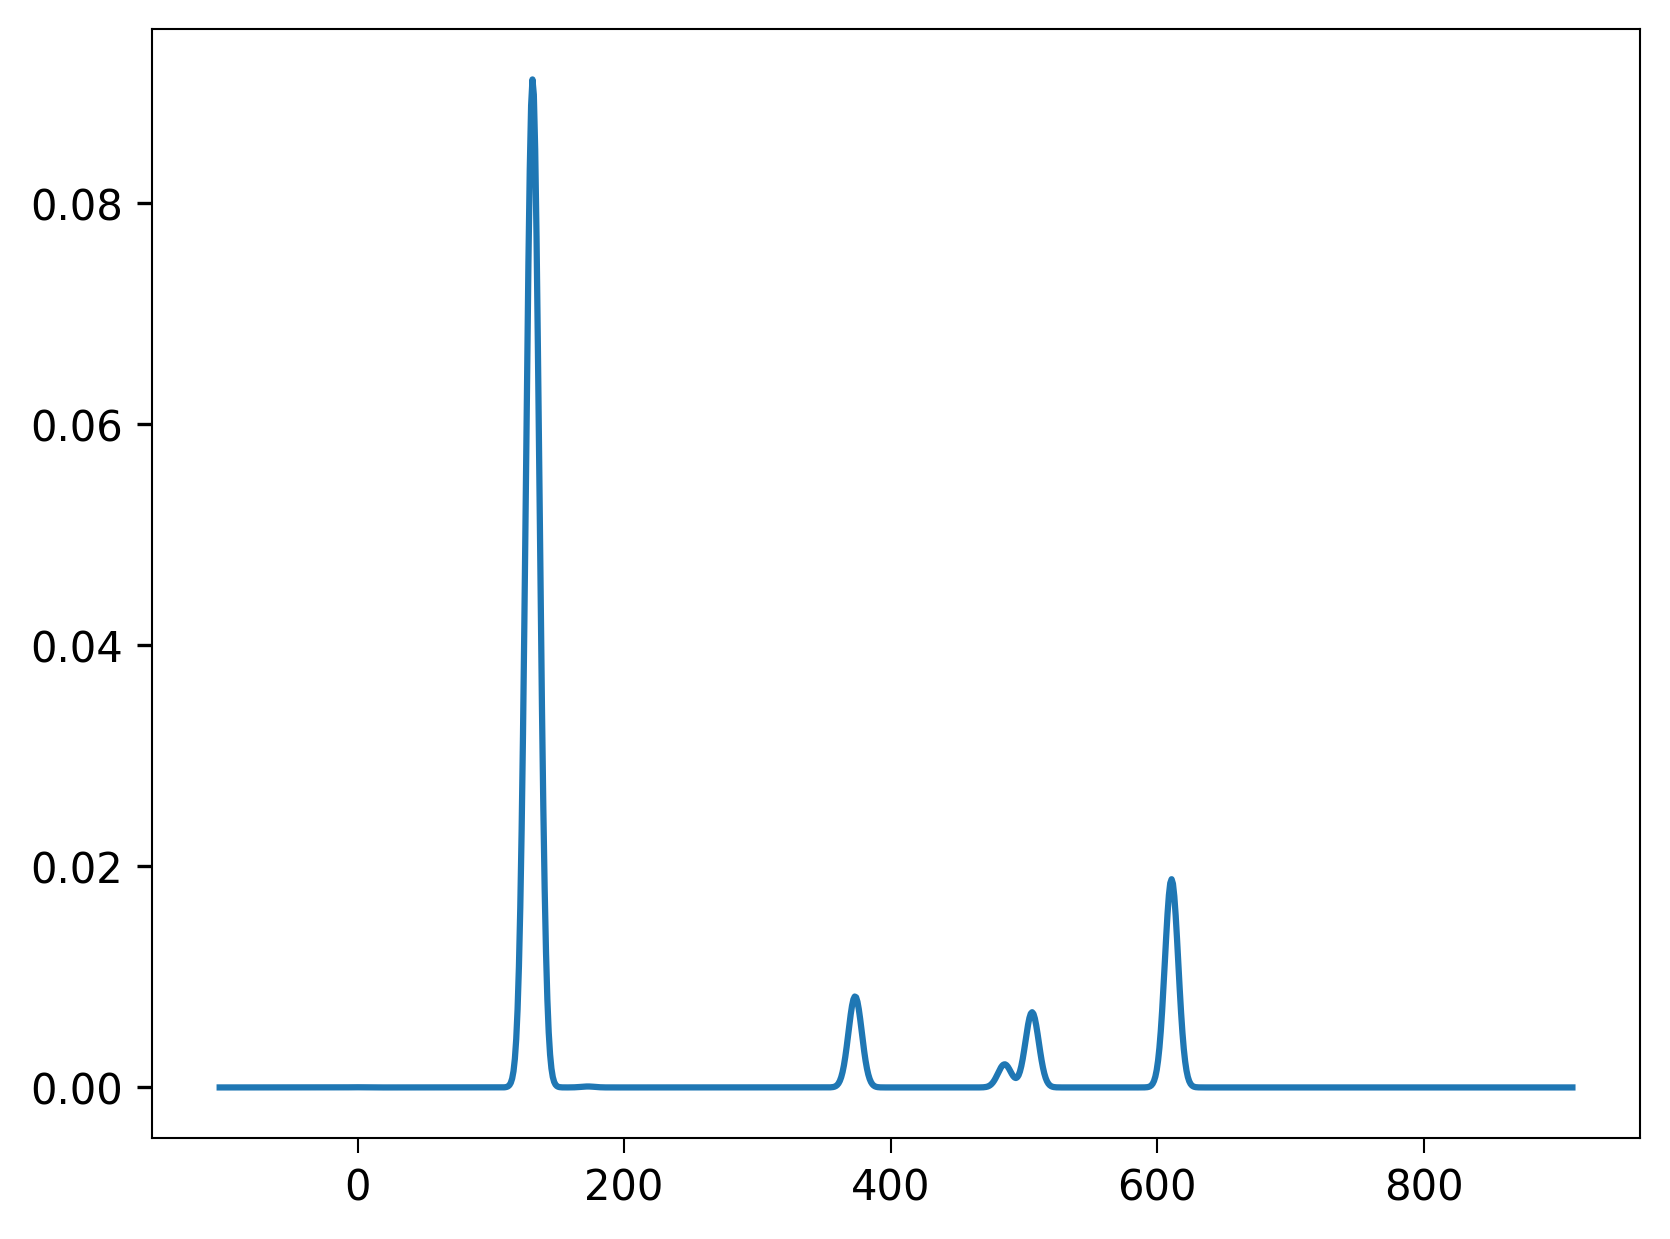

In [5]:
# Compute and plot spectrum
spectrum = phonons.get_raman_spectrum(model)
wavenumbers, total_intensities = spectrum.measure(laser_correction = True, 
                                           laser_wavelength = 532, 
                                           bose_einstein_correction = True, 
                                           temperature = 300)
wavenumbers, total_intensities = convolve_spectrum(wavenumbers, total_intensities)
fig = plt.figure()
axis = fig.add_subplot(111)
axis.plot(wavenumbers, total_intensities)

Now, one question we could ask is which parts of the Raman spectrum are associated with motion of Ti atoms and which parts are associated more with O atoms. In this case, we can produce two masked `ARTModel`'s, one with the Ti atoms masked and other with the O atoms masked.

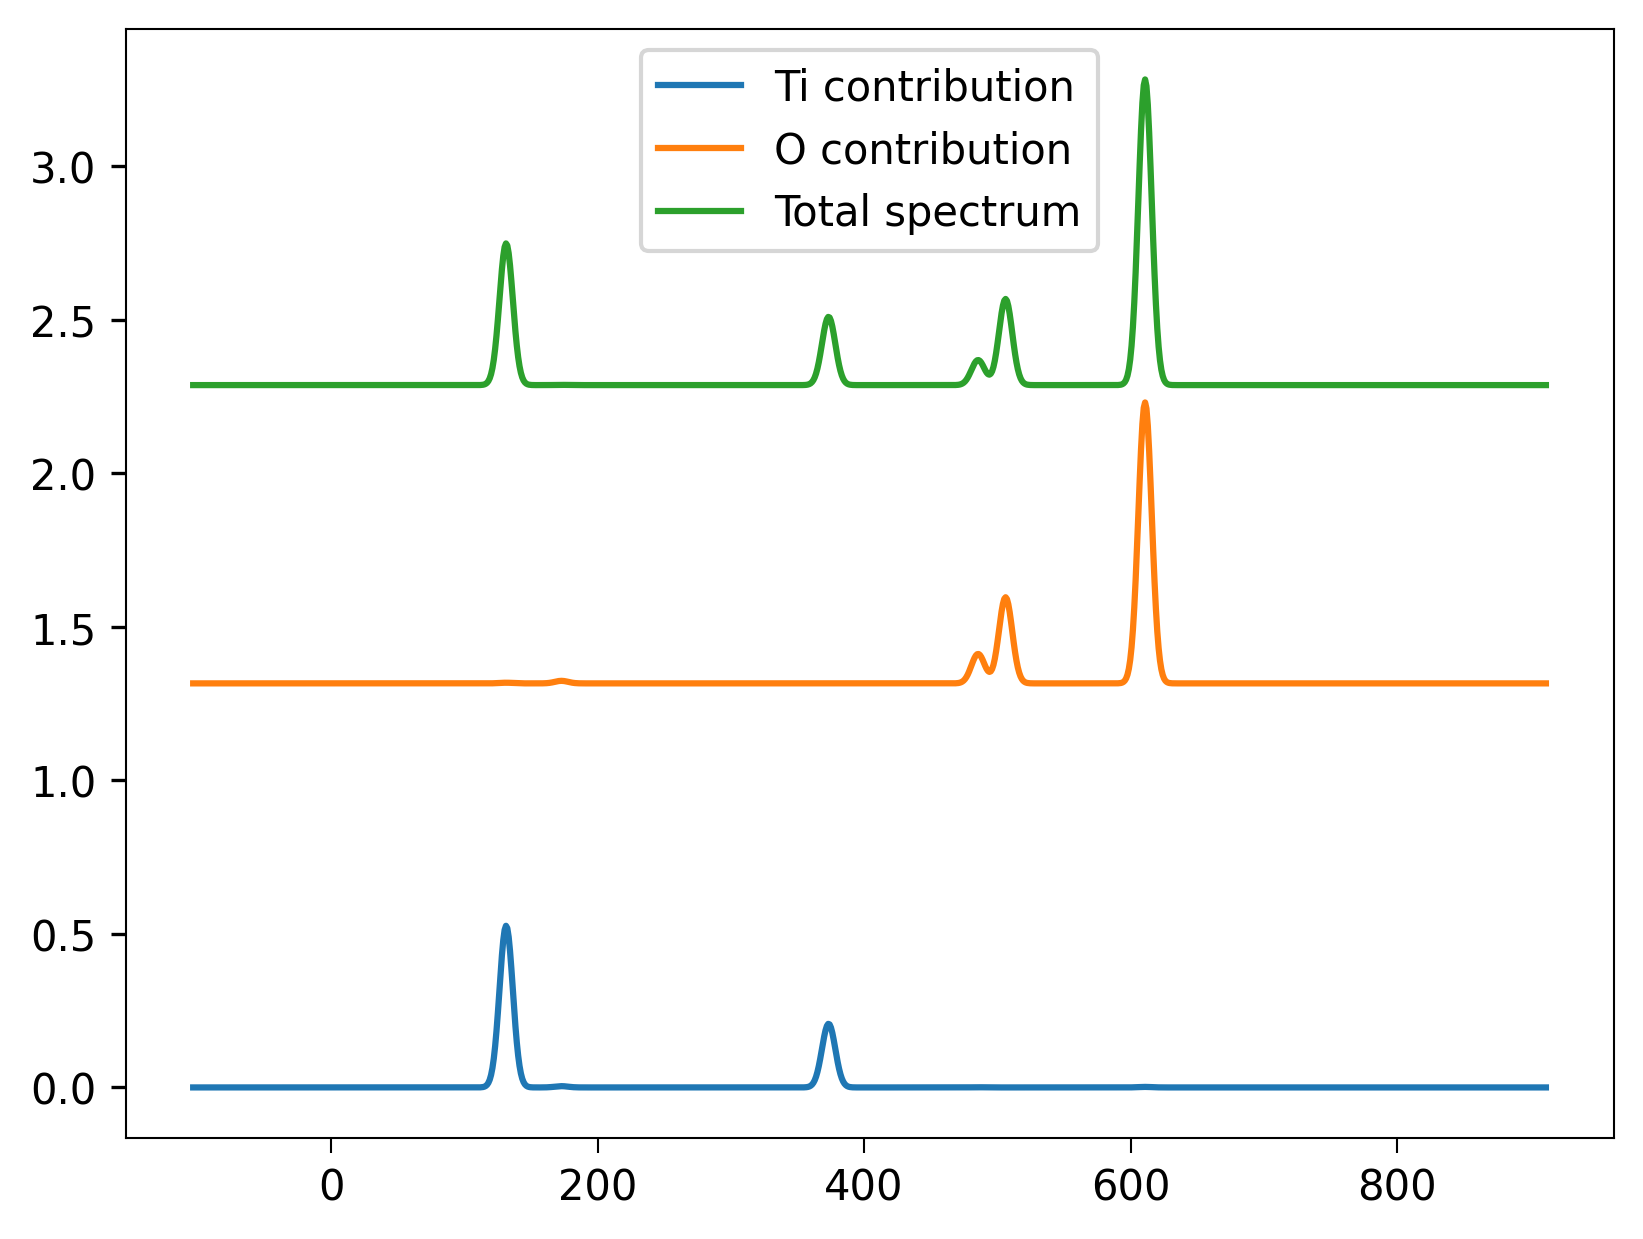

In [6]:
fig = plt.figure()
axis = fig.add_subplot(111)

total_model = model
O_dof_indexes = total_model.get_dof_indexes('O')
Ti_model = total_model.get_masked_model(O_dof_indexes) # Mask O to leave only Ti
Ti_dof_indexes = total_model.get_dof_indexes('Ti')
O_model = total_model.get_masked_model(Ti_dof_indexes) # Mask Ti to leave only O

offset = 0
models = [Ti_model, O_model, total_model]
labels = ['Ti contribution', 'O contribution', 'Total spectrum']
for plot_model, label in zip(models, labels):

    spectrum = phonons.get_raman_spectrum(plot_model)
    wavenumbers, intensities = spectrum.measure()
    wavenumbers, intensities = convolve_spectrum(wavenumbers, intensities)
    axis.plot(wavenumbers, intensities + offset, label = label)
    offset = np.max(intensities) * 2.5

l = axis.legend()



Convince yourself that this makes sense.

Hint: consider the vibrational frequencies of the heavier Ti atoms vs the lighter O atoms.

It is important keep track of masking, lest you unintentionally use one and believe the results represent the total spectrum. You can check a model's masking status using `repr`:

In [7]:
print(repr(O_model))
O_model # In Jupyter notebooks, the final variable is printed automatically

╭──────────────┬─────────────────────────────────────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions                                  │ Specified   │   Equivalent atoms │
├──────────────┼─────────────────────────────────────────────┼─────────────┼────────────────────┤
│            0 │ [-1. -0. +0.], [-0. -1. -0.], [-0. -0. +1.] │ 3/3         │                 35 │
│           36 │ [+0. +0. +1.], [+1. +0. -0.], [+0. +1. -0.] │ 3/3         │                 71 │
╰──────────────┴─────────────────────────────────────────────┴─────────────┴────────────────────╯
  ATTENTION: 108/324 atomic Raman tensors are masked. 


╭──────────────┬─────────────────────────────────────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions                                  │ Specified   │   Equivalent atoms │
├──────────────┼─────────────────────────────────────────────┼─────────────┼────────────────────┤
│            0 │ [-1. -0. +0.], [-0. -1. -0.], [-0. -0. +1.] │ 3/3         │                 35 │
│           36 │ [+0. +0. +1.], [+1. +0. -0.], [+0. +1. -0.] │ 3/3         │                 71 │
╰──────────────┴─────────────────────────────────────────────┴─────────────┴────────────────────╯
  ATTENTION: 108/324 atomic Raman tensors are masked. 

If in doubt, you can always use `unmask` to turn off masking.

In [8]:
O_model.unmask()
O_model

╭──────────────┬─────────────────────────────────────────────┬─────────────┬────────────────────╮
│   Atom index │ Directions                                  │ Specified   │   Equivalent atoms │
├──────────────┼─────────────────────────────────────────────┼─────────────┼────────────────────┤
│            0 │ [-1. -0. +0.], [-0. -1. -0.], [-0. -0. +1.] │ 3/3         │                 35 │
│           36 │ [+0. +0. +1.], [+1. +0. -0.], [+0. +1. -0.] │ 3/3         │                 71 │
╰──────────────┴─────────────────────────────────────────────┴─────────────┴────────────────────╯

Although this a very simple example, model masking is extremely powerful. By isolating the influence of individual atomic motions on the Raman spectrum, we can gain deep insight into the factors regulating the Raman shifts and Raman intensities of certain motions. In addition, masking gives us a straightforward way to isolate the Raman spectra of specific atoms or groups of atoms. This is useful in many cases, for example when considering defects.